In [1]:
import sys
#Python versiond
print(sys.version)

3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [2]:
#install requirements if needed
!pip install pandas cvxpy=1.0.31 matplotlib

In [50]:
#import modules
import cvxpy as cp
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import math
import os.path
import time

print(cp.__version__)

1.0.31


In [5]:
#read input dataset that was downladed from the binance 
fuldf = pd.read_pickle('data.pickle')

total_size = fuldf.shape[0]
print('Combined DF size:', total_size,'\nFull range: ', fuldf.iloc[0].name,fuldf.iloc[-1].name)
train_set = .5

train_id = int( total_size * train_set)
df_train = fuldf.iloc[:train_id]
df_test = fuldf.iloc[train_id:]
print('Training period: ', df_train.iloc[0].name,df_train.iloc[-1].name)
df_train.head()

Combined DF size: 1280 
Full range:  2017-12-13 00:00:00 2021-06-14 00:00:00
Training period:  2017-12-13 00:00:00 2019-09-13 00:00:00


,BTCUSDT,ETHUSDT,BNBUSDT,LTCUSDT
timestamp,,,,
2017-12-13,16033.29,683.99,2.7190,290.01
2017-12-14,16334.98,679.76,3.1519,272.40
2017-12-15,17539.83,674.95,4.1200,294.00
2017-12-16,19102.66,682.81,4.6378,293.97
2017-12-17,18860.02,707.64,5.9990,311.40


In [8]:
#Transform raw data to log-return format:
lret_data = np.log1p(df_train.pct_change()).dropna(axis=0,how='any')

In [17]:
#3 - SDF Estimation from BTC
#Using the above dataset we can estimate the SDF for BTC using 
# ETH, DJI, and CHY as factors.
#I will use cvxpy as a esetimator

y_label = fuldf.columns[0]
factors = fuldf.columns[1:].tolist()
R = lret_data[y_label].shift(1).iloc[1:].values.reshape((-1,1))
I = lret_data[factors].iloc[1:].values
assert R.shape[0] == I.shape[0] and I.shape[1]==3

print('R:',R.shape,'\n',R[:10]
,'\n I:',I.shape,'\n',I[:10,:])

R: (638, 1) 
 [[ 0.01864163]
 [ 0.07116547]
 [ 0.0853533 ]
 [-0.01278325]
 [-0.00019991]
 [-0.08641542]
 [-0.04773673]
 [-0.06232721]
 [-0.15060228]
 [-0.00199875]] 
 I: (638, 3) 
 [[-7.10118064e-03  2.67847718e-01  7.63081931e-02]
 [ 1.15780223e-02  1.18386953e-01 -1.02046023e-04]
 [ 3.57188534e-02  2.57352673e-01  5.76005381e-02]
 [ 1.02473531e-01  1.66680557e-04  1.22552916e-01]
 [ 1.76995771e-02 -5.13108384e-02 -3.91661692e-02]
 [-9.80986453e-03 -1.01413082e-01 -1.11722790e-01]
 [-9.91983310e-03  1.82350824e-03 -2.31519865e-03]
 [-2.07227507e-01 -1.84292643e-01 -1.85013920e-01]
 [ 6.84789287e-03  2.50381268e-02  9.71401093e-03]
 [ 2.72056460e-02  1.63393547e-01  3.66466231e-02]]


In [19]:
#correlation matrix
F= pd.concat([pd.DataFrame(R),pd.DataFrame(I)],axis=1)
F.columns =   [y_label]+factors
F.cov()

,BTCUSDT,ETHUSDT,BNBUSDT,LTCUSDT
BTCUSDT,0.001834,-0.000171,-0.000079,-0.000171
ETHUSDT,-0.000171,0.002841,0.002086,0.002459
BNBUSDT,-0.000079,0.002086,0.004515,0.002260
LTCUSDT,-0.000171,0.002459,0.002260,0.003091


In [20]:
#4 - Solve GMM problem
n = R.shape[0]
#define weights for the SDF
w = cp.Variable(shape=(3,1),nonneg=True)

#define SDF 
M = I @ w

#Define expression
Sigma = M @ R.T

#Construct the problem
prob = cp.Problem(cp.Minimize( cp.norm(Sigma)  )
                  # , [cp.geo_mean(M) >= 1 , ]
                 , [cp.sum(w) == 1 , ]
                  
                )

prob.solve(verbose=True
           #, max_iters = 300
           )

print('SDF weights from BTC:\n',w.value)

----------------------------------------------------------------------------
	SCS v2.1.3 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 3257634
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 814730, constraints m = 2035862
Cones:	primal zero / dual free vars: 1221133
	linear vars: 3
	sd vars: 814726, sd blks: 1
Setup time: 4.16e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.53e+21  7.88e+21  1.00e+00 -1.12e+19  1.39e+22  2.51e+21  3.24e+00 
    60| 2.09e-08  2.83e-07  6.12e-09  1.39e+00  1.39e+00  2.63e-18  5.34e+01 
-------------------------------------------------

In [66]:
'''
Calculate perofrmance of the model on the test data 
'''
#calculate return of the target variable (BTCUSDT)
y_return = (df_test[y_label].pct_change().fillna(0)+1).cumprod()



In [76]:
portfolio = df_test[factors].apply(lambda x: (x @ w.value)[0] ,axis =1)

p_return = ((portfolio.pct_change().fillna(0) + 1).cumprod()).rename('SDF Portfolio')

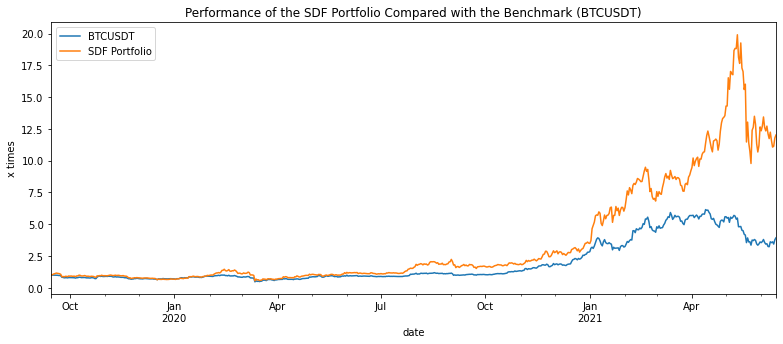

In [82]:
fig , ax = plt.subplots(figsize=(13,5))
portfolio_benchmark = pd.concat([y_return,p_return],axis=1)
portfolio_benchmark.plot(ax=ax);
ax.set(title='Performance of the SDF Portfolio Compared with the Benchmark (BTCUSDT)',ylabel='x times',xlabel='date');

In [86]:
print('Portfolio growth (x times):\n',
(portfolio_benchmark.iloc[-1] - 1).round(2).to_dict())

Portfolio growth (x times):
 {'BTCUSDT': 2.93, 'SDF Portfolio': 11.02}
